In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [43]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from scipy.stats import ttest_1samp, ttest_rel  # pip: scipy==1.10.1

from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from glob import glob as lsdir
from datetime import datetime
import time
import os
import pickle
import json
import warnings


Download dataset and set up paths

In [18]:
basedir = os.path.split(os.getcwd())[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

if not os.path.exists(figdir):
    os.makedirs(figdir)

if not os.path.exists(datadir):
    os.makedirs(datadir)

data_url = 'https://www.dropbox.com/s/99ty0ok8p4m5ijc/data.zip?dl=1'
data_fname = os.path.join(basedir, 'data.zip')
checkfile_fname = os.path.join(datadir, 'checkfile.txt')

if not os.path.exists(data_fname) and not os.path.exists(checkfile_fname):
    print('Downloading data...')
    r = requests.get(data_url, allow_redirects=True)
    open(data_fname, 'wb').write(r.content)

if os.path.exists(data_fname) and not os.path.exists(checkfile_fname):
    print('Unzipping data...')
    !unzip -q $data_fname -d $basedir
    !rm $data_fname
    !rm -rf $basedir/__MACOSX

    with open(checkfile_fname, 'w') as f:
        f.write('download complete.')

Unzipping data...


Parse behavioral and eyetracking data files

In [86]:
def parse_behavioral_data(datadir):
    def get_pres_time(image, stim_type, log):
        if type(image) is str:
            image_times = log.loc[log['Info'].apply(lambda x: (image in x) and (stim_type in x) if type(x) is str else False)]
            assert image_times.shape[0] == 4, Exception(f'Image {image} appears the wrong number of times')
            return image_times.iloc[-2]['Time'], image_times.iloc[-1]['Time']
        else:
            return np.nan, np.nan
        
    def add_timing_info(subj_df):
        def timing_helper(x, log):
            image = np.nan
            stim_type = ''
            if image is np.nan:
                image = x['Cued Composite']
                stim_type = 'CUED COMPOSITE'
            if image is np.nan:
                image = x['Memory Image']
                stim_type = 'MEMORY IMAGE'
            
            return get_pres_time(image, stim_type, log)
        
        result = []
        runs = np.unique(subj_df['Run'])
        for i in runs:
            log = pd.read_csv(os.path.join(datadir, subj_df['Subject'].values[0], f'-{i}.log'), delimiter='\t', header=None, names=['Time', 'Event', 'Info'])
            start_time = float(log[log['Info'].apply(lambda x: 'current time: ' in x if type(x) is str else False)]['Info'].values[0].split()[-1])
            
            x = subj_df.query('Run == @i').copy()
            next_times = x.apply(lambda y: timing_helper(y, log), axis=1)

            x['Stimulus Onset'] = [float(t[0]) + start_time for t in next_times]
            x['Stimulus Offset'] = [float(t[1]) + start_time for t in next_times]

            result.append(x.drop('Stimulus End', axis=1))
        return pd.concat(result, ignore_index=True)

    def helper(subjdir):
        subj = os.path.basename(subjdir)

        pres_fnames = lsdir(os.path.join(subjdir, 'pres*.csv'))
        mem_fnames = lsdir(os.path.join(subjdir, 'mem*.csv'))

        pres = pd.concat([pd.read_csv(fname) for fname in pres_fnames], ignore_index=True)
        mem = pd.concat([pd.read_csv(fname) for fname in mem_fnames], ignore_index=True)
        
        df = pd.concat([pres, mem], ignore_index=True).sort_values(['Run']).drop('Unnamed: 0', axis=1)
        df['Subject'] = subj
        df = add_timing_info(df)
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    data = []
    for subjdir in tqdm(subjdirs):
        data.append(helper(subjdir))
    return pd.concat(data, ignore_index=True)

In [87]:
sustained_behavioral = parse_behavioral_data(os.path.join(datadir, 'sustained'))
variable_behavioral = parse_behavioral_data(os.path.join(datadir, 'variable'))

100%|██████████| 23/23 [00:08<00:00,  2.74it/s]


In [21]:
sustained_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Attention Probe,Stimulus Offset
0,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00753941201fa.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.570973e+09,NaN,1.570973e+09
1,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.570973e+09,NaN,1.570973e+09
2,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00779941205fa.jpg,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1.570973e+09,NaN,1.570973e+09
3,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunafbwnojpqeyzssoe.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.570973e+09,NaN,1.570973e+09
4,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaaeplwsfslcbtojr.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.570973e+09,NaN,1.570973e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunajtrfunvzdfticna.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.571074e+09,NaN,1.571074e+09
11996,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunagdzlvkqtpnfxfcg.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.571074e+09,NaN,1.571074e+09
11997,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunayaepykrqvenaqqy.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.571074e+09,NaN,1.571074e+09
11998,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.571074e+09,NaN,1.571074e+09


In [22]:
variable_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Attention Probe,Stimulus Offset
0,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00720960620fa.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.582317e+09,NaN,1.582317e+09
1,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunagufzbeteqdjxais.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.582317e+09,NaN,1.582317e+09
2,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaecpkgfewqqreqwe.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.582317e+09,NaN,1.582317e+09
3,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00146960620fb.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.582317e+09,NaN,1.582317e+09
4,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunbpflsdaxnddnwcqi.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.582317e+09,NaN,1.582317e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00062931230fb.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.581101e+09,NaN,1.581101e+09
9196,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00198940128fb.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.581101e+09,NaN,1.581101e+09
9197,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00184940128fa.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,1.581101e+09,NaN,1.581101e+09
9198,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunabcuurugvxwparpk.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1.581101e+09,NaN,1.581101e+09


In [88]:
def parse_gaze_data(datadir):
    def multi_get(d, keys):
        if type(d) is list:
            x = [multi_get(i, keys) for i in d]
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')  # ignore typecast deprecation warning
                return pd.DataFrame.from_dict(x)

        if type(keys) is dict:
            return {k: multi_get(d, v) for k, v in keys.items()}

        vals = []
        for k in keys:
            if type(k) is list:
                vals.append(multi_get(d, k))
            elif k in d:
                d = d[k]
            else:
                return np.nan
        if len(vals) == 0:
            return d
        else:
            try:
                if len(vals) == 0 or np.isnan(vals).all():
                    return np.nan
                return np.nanmean(vals)
            except:
                return vals
    
    gaze_dict = {'Time': ['values', 'frame', 'timestamp'],
             'x': ['values', 'frame', 'avg', 'x'],
             'y': ['values', 'frame', 'avg', 'y'],
            'Pupil size': [['values', 'frame', 'lefteye', 'psize'], ['values', 'frame', 'righteye', 'psize']]}

    str2unix = lambda t: time.mktime(datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f').timetuple())
    
    def helper(subjdir):
        subj = os.path.basename(subjdir)

        gaze_data_files = lsdir(os.path.join(subjdir, 'eye_data', '*_*'))
        gaze_data = []
        for g in gaze_data_files:
            with open(g, 'r') as f:
                content = f.readlines()
                
                data = []
                for line in content:
                    try:
                        data.append(json.loads(line))
                    except:
                        pass # ignore lines that can't be parsed as json
            
            df = multi_get(data, gaze_dict)
            df['Subject'] = subj
            df['Run'] = int(os.path.basename(g).split('_')[1])

            # convert x and y values to cm
            if df.shape[0] > 0:
                df['x'] = df['x'] * (59.8 / 2048)
                df['y'] = df['y'] * (33.6 / 1152)            

                # drop missing or invalid data (pupil size <= 0, x or y off screen)
                gaze_data.append(df.query('`Pupil size` > 0 & x > 0 & y > 0 & x < 59.8 & y < 33.6').dropna(how='all', axis=0))

        # drop missing or invalid data (pupil size <= 0, x or y <= 0)
        df = pd.concat(gaze_data, axis=0, ignore_index=True).dropna(how='all', axis=0)

        try:
            df['Time'] = df['Time'].apply(str2unix)
        except:
            pass
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    data = []
    for subjdir in tqdm(subjdirs):
        data.append(helper(subjdir))
    return pd.concat(data, ignore_index=True)

In [89]:
sustained_gaze = parse_gaze_data(os.path.join(datadir, 'sustained'))
variable_gaze = parse_gaze_data(os.path.join(datadir, 'variable'))

100%|██████████| 23/23 [04:59<00:00, 13.01s/it]


In [90]:
sustained_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.570973e+09,33.489124,10.306934,16.70270,34_2019_Oct_13,2
1,1.570973e+09,33.457396,10.330854,16.72500,34_2019_Oct_13,2
2,1.570973e+09,33.255358,10.486799,16.73945,34_2019_Oct_13,2
3,1.570973e+09,33.265260,10.478487,16.79585,34_2019_Oct_13,2
4,1.570973e+09,33.210056,10.520274,16.82780,34_2019_Oct_13,2
...,...,...,...,...,...,...
1920643,1.571072e+09,16.626686,28.935629,12.43825,9_2019_Oct_14,1
1920644,1.571072e+09,5.635703,25.184130,8.77160,9_2019_Oct_14,1
1920645,1.571072e+09,5.521412,24.949549,8.28955,9_2019_Oct_14,1
1920646,1.571072e+09,2.779392,24.202658,11.96100,9_2019_Oct_14,1


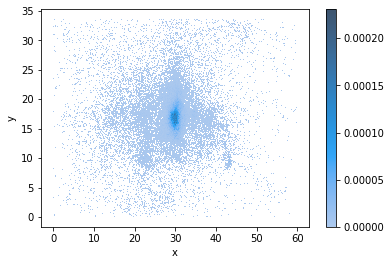

In [91]:
sns.histplot(sustained_gaze, x='x', y='y', cbar=True, stat='probability');

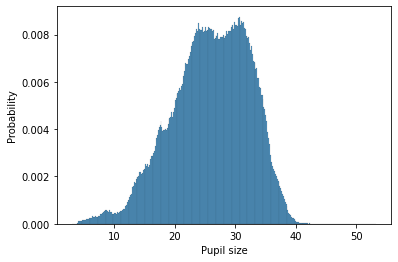

In [92]:
sns.histplot(sustained_gaze, x='Pupil size', stat='probability');

In [72]:
variable_gaze

,Time,x,y,Pupil size,Subject,Run
0,1.582318e+09,40.205193,20.145700,17.87420,56_2020_Feb_21,2
1,1.582318e+09,32.750250,13.563597,19.89075,56_2020_Feb_21,2
2,1.582318e+09,32.536114,13.896569,19.31620,56_2020_Feb_21,2
3,1.582318e+09,32.413656,14.081387,19.59020,56_2020_Feb_21,2
4,1.582318e+09,32.396244,14.127362,19.00590,56_2020_Feb_21,2
...,...,...,...,...,...,...
2778320,1.581100e+09,33.578999,8.434443,9.70405,0_2020_Feb_07,1
2778321,1.581100e+09,33.582716,8.580510,16.17045,0_2020_Feb_07,1
2778322,1.581100e+09,33.581367,8.714320,16.37225,0_2020_Feb_07,1
2778323,1.581100e+09,33.583046,8.801126,16.40765,0_2020_Feb_07,1


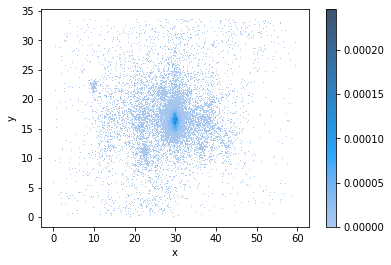

In [93]:
sns.histplot(variable_gaze, x='x', y='y', cbar=True, stat='probability');

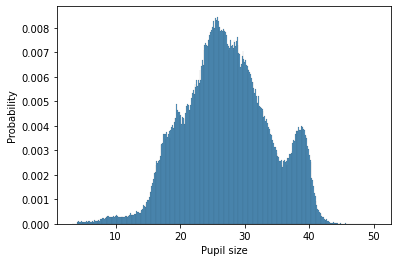

In [94]:
sns.histplot(variable_gaze, x='Pupil size', stat='probability');